In [1]:
# import necessary modules
# uncomment to get plots displayed in notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_sz import Class
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import math
# SO RMS data
import os
import nemo as nm

In [2]:
# esthetic definitions for the plots
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]

# From Matt's files to class_sz selection function format

In [3]:
path_to_catalogue = '/Users/boris/Work/CLASS-SZ/SO-SZ/so_cluster_counts/MFMF_WebSkyHalos_A10tSZ_3freq_tiles/'
path_to_selfn = '/Users/boris/Work/CLASS-SZ/SO-SZ/so_cluster_counts/MFMF_WebSkyHalos_A10tSZ_3freq_tiles/selFn/'
Qfits  = path_to_selfn + 'QFit.fits'

In [4]:
from astropy.io import fits
#"fits_image_filename = fits.util.get_testdata_filepath(path_to_catalogue+'MFMF_SOSim_3freq_tiles_M500.fits')
tcat = path_to_catalogue+'MFMF_WebSkyHalos_A10tSZ_3freq_tiles_mass.fits'
list = fits.open(tcat)
data = list[1].data
z = data.field("redshift")
snr = data.field("SNR")
tile = data.field("tileName")




In [5]:
# path_to_selfn = '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_external_data_and_scripts/MFMF_SOSim_3freq_tiles/selFn/'
RMS_table = path_to_selfn +'RMSTab.fits'
tile_area = np.genfromtxt(os.path.join(path_to_selfn, 'tileAreas.txt'), dtype=str)

In [6]:
list = fits.open(RMS_table)
data = list[1].data

In [7]:
list[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   23 / length of dimension 1                          
NAXIS2  =                61169 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TTYPE1  = 'areaDeg2'                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'y0RMS   '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'tileName'        

In [8]:
skyfracs = data.field("areaDeg2")
noise = data.field("y0RMS")
tname = data.field("tileName")
tilename = tile_area[:,0]
np.size(tilename)
skyfracs.size

61169

In [9]:
# downsampling
skyfracs0 = []
noise0 = []
tname0 = []

downsample = 50
stepSize = downsample*1e-7
binEdges = np.arange(min(noise), max(noise)+stepSize, stepSize)
#print(len(binEdges)-1)

for i in range(len(tilename)):
     noise_tile = []
     skyfracs_tile = []
     tname_tile = []

     for j in range(len(noise)):
         if tname[j] == tilename[i]:
             noise_tile.append(noise[j])
             skyfracs_tile.append(skyfracs[j])
             tname_tile.append(tname[j])

     noise_arr = np.array(noise_tile)
     skyfracs_arr = np.array(skyfracs_tile)
     tname_arr = np.array(tname_tile)

     skyfracs_masked = []
     noise_masked = []
     tname_masked = []

     for k in range(len(binEdges)-1):
         mask = np.logical_and(noise_arr >= binEdges[k], noise_arr < binEdges[k+1])
         if mask.sum() > 0:
             noise_masked.append(np.average(noise_arr[mask], weights=skyfracs_arr[mask]))
             skyfracs_masked.append(np.sum(skyfracs_arr[mask]))
             tname_masked.append(tilename[i])

     noise0.append(noise_masked)
     skyfracs0.append(skyfracs_masked)
     tname0.append(tname_masked)

#print(len(noise0))
noise = np.array([item for singleList in noise0 for item in singleList])
skyfracs = np.array([item for singleList in skyfracs0 for item in singleList])*np.deg2rad(1.)**2.
tname_reduced = np.array([item for singleList in tname0 for item in singleList])

tname = []

for i in range(len(tname_reduced)):
    for j in range(len(tilename)):
        if tname_reduced[i] == tilename[j]:
            tname.append(j+1)

tname = np.array(tname)

print("\r Noise map is downsampled to speed up a completeness compuation by %d" %downsample)
print("\r Number of sky patches = ", skyfracs.size)


print("\r Entire survey area = ", skyfracs.sum()/(np.deg2rad(1.)**2.), "deg2")



 Noise map is downsampled to speed up a completeness compuation by 50
 Number of sky patches =  451
 Entire survey area =  17884.52780056928 deg2


In [10]:
list = fits.open(Qfits)
data = list[1].data
list[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   24 / length of dimension 1                          
NAXIS2  =                   51 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
NEMOVER = '0.4.0b3+120.g542317d.dirty'                                          
ZDEPQ   =                    0                                                  
EXTNAME = '1_0_0   '           / extension name                                 
TTYPE1  = 'Q       '                                                            
TFORM1  = 'D       '        

In [11]:
# Nt = len(tilename)
# print("\r Number of tiles = ", Nt)


# list = fits.open(Qfits)
# data = list[1].data
# tt500 = data.field("theta500Arcmin")

# # reading in all Q functions
# allQ = np.zeros((len(tt500),Nt))
# for i in range(Nt):
# #     allQ[:,i] = data.field(tilename[i])
#     allQ[:,i] = data.field('Q') # seems like only one Q function
# assert len(tt500) == len(allQ[:,0])


# # meanQ = np.delete(allQ, np.s_[103,328], axis=1) # manually for now
# meanQ = allQ
# Q = np.mean(meanQ, axis=1)
# print("\r Number of Q functions = ", Q.ndim)
# print("\r Using one averaged Q function for optimisation")



In [12]:
QFit = nm.signals.QFit(QFitFileName = path_to_selfn + 'QFit.fits', tileNames = tile_area[:,0])

In [13]:
Nt = len(tilename)
print("\r Number of tiles = ", Nt)


list = fits.open(Qfits)
data = list[1].data
tt500 = data.field("theta500Arcmin")

# reading in all Q functions
allQ = np.zeros((len(tt500),Nt))
for i in range(Nt):
#     allQ[:,i] = data.field(tilename[i])
#     allQ[:,i] = data.field('Q') # seems like only one Q function
    allQ[:,i] = QFit.getQ(data.field("theta500Arcmin"),tileName = tile_area[:,0][i])
assert len(tt500) == len(allQ[:,0])


# meanQ = np.delete(allQ, np.s_[103,328], axis=1) # manually for now
meanQ = allQ
Q = np.mean(meanQ, axis=1)
print("\r Number of Q functions = ", Q.ndim)
print("\r Using one averaged Q function for optimisation")



 Number of tiles =  346
 Number of Q functions =  1
 Using one averaged Q function for optimisation


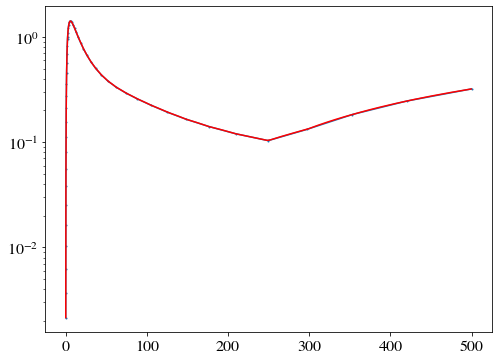

In [14]:
plt.plot(tt500,Q,marker='o',markersize=1.)
plt.yscale('log')
import scipy
Q_interp = scipy.interpolate.interp1d(tt500,Q)
new_th = np.geomspace(1.0001*(tt500.min()),0.999*(tt500.max()),500)
plt.plot(new_th,Q_interp(new_th),c='r')
Q_new_th = Q_interp(new_th)
plt.show()

In [17]:
rad_in_deg2 = (np.deg2rad(1.))**2.
np.savetxt(path_to_catalogue+'so_3freqs_191121_theta500arcmin_Q.txt',np.c_[tt500,Q])
np.savetxt(path_to_catalogue+'so_3freqs_191121_skyfracs.txt',np.c_[skyfracs/rad_in_deg2/41253.])


In [18]:
so_skyfracs = np.loadtxt(path_to_catalogue+'so_3freqs_191121_skyfracs.txt')
so_ylims = []
for index_thetas in range(Q.size):
    for id_patches in range(so_skyfracs.size):
        so_ylims.append(noise[id_patches]/Q[index_thetas])
so_ylims = np.asarray(so_ylims)
np.savetxt(path_to_catalogue+'so_3freqs_191121_ylims.txt',np.c_[so_ylims])
np.savetxt(path_to_catalogue+'so_3freqs_191121_thetas.txt',np.c_[tt500])

In [ ]:
so_ylims = []
for index_thetas in range(Q.size):
    for id_patches in range(so_skyfracs.size):
        so_ylims.append(noise[id_patches]/Q[index_thetas])
so_ylims = np.asarray(so_ylims)
np.savetxt(path_to_catalogue+'so_3freqs_120921_pass2_ylims.txt',np.c_[so_ylims])
np.savetxt(path_to_catalogue+'so_3freqs_120921_pass2_thetas.txt',np.c_[tt500])

# Read in the catalogue

In [35]:
path_to_catalogue = '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_external_data_and_scripts/MFMF_SOSim_3freq_tiles/'

In [36]:
from astropy.io import fits
#"fits_image_filename = fits.util.get_testdata_filepath(path_to_catalogue+'MFMF_SOSim_3freq_tiles_M500.fits')
tcat = path_to_catalogue+'MFMF_SOSim_3freq_tiles_M500.fits'
list = fits.open(tcat)
data = list[1].data
z = data.field("redshift")
snr = data.field("SNR")
tile = data.field("tileName")




In [37]:
print(data.columns)

ColDefs(
    name = 'name'; format = '18A'
    name = 'RADeg'; format = 'D'
    name = 'decDeg'; format = 'D'
    name = 'SNR'; format = 'D'
    name = 'numSigPix'; format = 'D'
    name = 'template'; format = '17A'
    name = 'tileName'; format = '7A'
    name = 'galacticLatDeg'; format = 'D'
    name = 'fixed_SNR'; format = 'D'
    name = 'deltaT_c'; format = 'D'
    name = 'err_deltaT_c'; format = 'D'
    name = 'y_c'; format = 'D'
    name = 'err_y_c'; format = 'D'
    name = 'fixed_deltaT_c'; format = 'D'
    name = 'fixed_err_deltaT_c'; format = 'D'
    name = 'fixed_y_c'; format = 'D'
    name = 'fixed_err_y_c'; format = 'D'
    name = 'redshift'; format = 'D'
    name = 'redshiftErr'; format = 'D'
    name = 'M500'; format = 'D'
    name = 'M500_errPlus'; format = 'D'
    name = 'M500_errMinus'; format = 'D'
    name = 'M500Uncorr'; format = 'D'
    name = 'M500Uncorr_errPlus'; format = 'D'
    name = 'M500Uncorr_errMinus'; format = 'D'
    name = 'M200m'; format = 'D'
    name

In [6]:
snrcut = 5
z = z[snr > snrcut]
snr = snr[snr > snrcut]

np.shape(z)
np.log(snrcut)

1.6094379124341003

In [7]:
z.max()

2.769250813231601

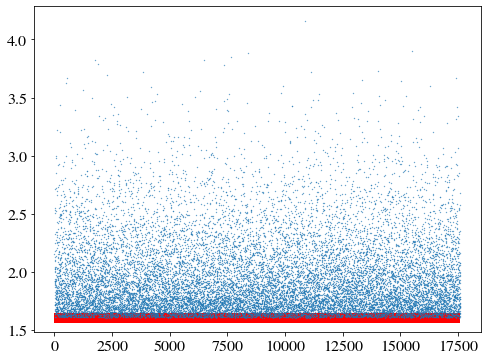

In [8]:
plt.plot(np.log(snr),marker='o',ls='None',markersize=0.3)
plt.hlines(np.log(snrcut),xmin=0,xmax=len(snr),color='r',lw=10)

In [9]:
# redshift bins
dz = 0.1
z_min = 0.
z_max = 2.8

In [10]:
(z_max-z_min)/dz

27.999999999999996

In [11]:
nbins_z = int( np.floor((z_max-z_min)/dz) + 1)
nbins_z += 1
nbins_z

29

In [12]:
z_bin_edges = np.zeros(nbins_z+1)
z_bin_edges[0] = z_min
for i in range(1,nbins_z):
    z_bin_edges[i] = z_bin_edges[i-1]+dz
z_bin_edges[nbins_z] = z_max+dz
z_bin_centers = np.zeros(nbins_z)
for i in range(0,nbins_z):
    z_bin_centers[i] = z_bin_edges[i]+(z_bin_edges[i+1]-z_bin_edges[i])/2.
z_bin_centers

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05,
       1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95, 2.05, 2.15,
       2.25, 2.35, 2.45, 2.55, 2.65, 2.75, 2.85])

In [13]:
N_clusters_z, xedges = np.histogram(z, bins=z_bin_edges)

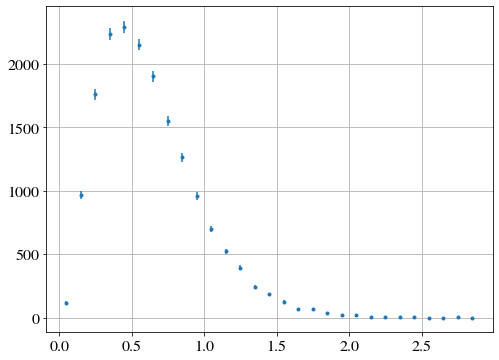

In [14]:
plt.errorbar(z_bin_centers,N_clusters_z,yerr=np.sqrt(N_clusters_z),marker='o',markersize=3.,ls='none')
plt.grid()

In [15]:
np.log10(32.)

1.505149978319906

In [16]:
# snr bins
dlnsnr = 0.1
lnsnr_min = np.log10(snrcut)
lnsnr_max = np.log10(snr.max()+1.)

In [17]:
lnsnr_min

0.6989700043360189

In [18]:
lnsnr_max

1.8124259665302023

In [19]:
nbins_lnsnr = int( np.floor((lnsnr_max-lnsnr_min)/dlnsnr) + 1)
nbins_lnsnr

12

In [20]:
lnsnr_bin_edges = np.zeros(nbins_lnsnr+2)
lnsnr_bin_edges[0] = lnsnr_min 
for i in range(1,nbins_lnsnr+2):
    lnsnr_bin_edges[i] = lnsnr_bin_edges[i-1]+dlnsnr
# lnsnr_bin_edges[nbins_lnsnr] = lnsnr_max + dlnsnr
lnsnr_bin_centers = np.zeros(nbins_lnsnr+1)
for i in range(0,nbins_lnsnr+1):
    lnsnr_bin_centers[i] = lnsnr_bin_edges[i]+dlnsnr/2.
10**lnsnr_bin_centers

array([ 5.61009227,  7.06268772,  8.89139705, 11.19360569, 14.09191466,
       17.74066946, 22.33417961, 28.11706626, 35.39728922, 44.56254691,
       56.10092272, 70.62687723, 88.9139705 ])

In [21]:
lnsnr_bin_edges

array([0.69897, 0.79897, 0.89897, 0.99897, 1.09897, 1.19897, 1.29897,
       1.39897, 1.49897, 1.59897, 1.69897, 1.79897, 1.89897, 1.99897])

In [22]:
N_clusters_lnsnr, xedges = np.histogram(np.log10(snr), bins=lnsnr_bin_edges)
N_clusters_lnsnr

array([8756, 4234, 2242, 1209,  608,  308,  126,   72,   28,   11,    0,
          1,    0])

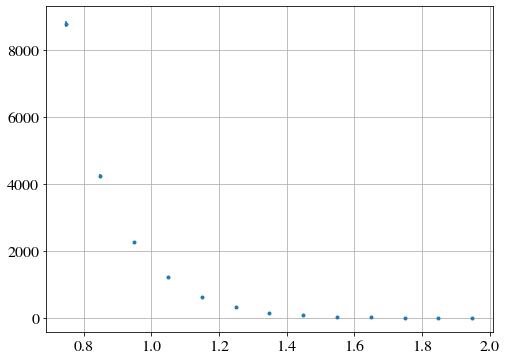

In [23]:
plt.errorbar(lnsnr_bin_centers,N_clusters_lnsnr,yerr=np.sqrt(N_clusters_lnsnr),marker='o',markersize=3.,ls='none')
plt.grid()